<a href="https://colab.research.google.com/github/AnaBelenCarbajal/Thesis-Experiment-3/blob/main/Fine_tuning_on_animal_dataset_textue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset animal shapes**

1) installing packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install osculari

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nv

In [3]:
# importing required packages
import osculari

import numpy as np
from matplotlib import pyplot as plt
import torch
import os
from random import choice
import pandas as pd

from torchvision.datasets import ImageFolder
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset
import torchvision.transforms.functional as transform
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.transforms import Pad
from torch.utils.data import DataLoader
import cv2

from PIL import Image

2) I uploaded images180.zip to this collab, it needs to be unzipped

In [4]:
# unzip folder (previously uploaded in collab)
!unzip images180.zip -d my_data

Streaming output truncated to the last 5000 lines.
  inflating: my_data/images180/images224/horse/88.png  
  inflating: my_data/__MACOSX/images180/images224/horse/._88.png  
  inflating: my_data/images180/images224/horse/77.png  
  inflating: my_data/__MACOSX/images180/images224/horse/._77.png  
  inflating: my_data/images180/images224/horse/63.png  
  inflating: my_data/__MACOSX/images180/images224/horse/._63.png  
  inflating: my_data/images180/images224/horse/62.png  
  inflating: my_data/__MACOSX/images180/images224/horse/._62.png  
  inflating: my_data/images180/images224/horse/76.png  
  inflating: my_data/__MACOSX/images180/images224/horse/._76.png  
  inflating: my_data/images180/images224/horse/89.png  
  inflating: my_data/__MACOSX/images180/images224/horse/._89.png  
  inflating: my_data/images180/images224/horse/60.png  
  inflating: my_data/__MACOSX/images180/images224/horse/._60.png  
  inflating: my_data/images180/images224/horse/74.png  
  inflating: my_data/__MACOSX/im

3) Root: directory to the filder containing the aniam categories

In [5]:
# root directory to data
root = "my_data/images180/images180/"

4) Labels: categories

In [6]:
# get category labels
labels = os.listdir(root)

#remove ".DS_Store"
labels.remove(".DS_Store")

5) Retrieve label and image information in dictionary for every image -> list of dictionaries

In [7]:
# get list of dictionaries with respective label and image number for all images
data = []

for label in labels:
  folder_path = root + label
  shapes = os.listdir(folder_path)
  for shape in shapes:
    category_dict = {'label': label, 'image': shape}
    data.append(category_dict)

6) Retireve image directory

In [8]:
# function to get image directory
def image_direct(root, category_dict_item):
  return root + category_dict_item['label'] + "/" + category_dict_item['image']

# get image directories
img_dir = []
for image in data:
  direct = image_direct(root, image)
  img_dir.append(direct)

8) Append image directory and size to dictionary

In [9]:
# add img_dir and img_size to data
for img in data:
  for dir in img_dir:
    img['img_dir'] = dir

** Compute random positions -> random

In [10]:
# height, width combinations
combinations = []
for left_and_right in range(-22,23):
    for up_and_down in range(-22,23):
        combinations.append((left_and_right, up_and_down))

# margins
left = 22
right = 22
top = 22
bottom = 22

# make combinations for left, top, right and bottom
i = 0
new_combinations = []
for position in combinations:
  left_new = left - position[0]
  right_new = right + position[0]
  top_new = top + position[1]
  bottom_new = bottom - position[1]
  new_combinations.append([left_new, top_new, right_new, bottom_new])

# random positions
positions = []
for i in new_combinations:
  pd.Series([1, 2, 3])
  j = pd.Series(i)
  jj = j.to_list()
  positions.append(jj)

** Segment foreground and background to apply ColorJitter transformation separetly

In [20]:
class ImageProcessor:
    def __init__(self, brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1, texture_transform=None):
        self.color_jitter = transforms.ColorJitter(
            brightness=brightness,
            contrast=contrast,
            saturation=saturation,
            hue=hue
        )
        self.texture_transform = texture_transform

    def separate_foreground_background(self, image_np):
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        _, mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)
        mask_3c = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        mask_inv_3c = cv2.cvtColor(mask_inv, cv2.COLOR_GRAY2BGR)
        foreground = cv2.bitwise_and(image_np, mask_3c)
        background = cv2.bitwise_and(image_np, mask_inv_3c)
        return foreground, background, mask, mask_inv

    def apply_transform(self, image_np):
        image_pil = Image.fromarray(image_np)
        transformed_image = self.color_jitter(image_pil)
        return np.array(transformed_image)

    def combine_images(self, foreground, background, mask, mask_inv):
        # Use the mask to combine the transformed foreground and background
        combined_image = cv2.bitwise_and(foreground, foreground, mask=mask)
        combined_image += cv2.bitwise_and(background, background, mask=mask_inv)
        return combined_image

    def process_image(self, image_tensor):
        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert to numpy array in HWC format
        image_np = (image_np * 255).astype(np.uint8)  # Convert to uint8 range [0, 255]

        foreground, background, mask, mask_inv = self.separate_foreground_background(image_np)
        transformed_foreground = self.apply_transform(foreground)
        transformed_background = self.apply_transform(background)
        if self.texture_transform:
          transformed_background = self.texture_transform(transformed_background)
        combined_image = self.combine_images(transformed_foreground, transformed_background, mask, mask_inv)
        combined_image = combined_image.astype(np.float32) / 255.0  # Normalize back to [0, 1] range
        combined_image = torch.from_numpy(combined_image).permute(2, 0, 1)  # Convert back to tensor in CHW format
        return combined_image

In [21]:
import cv2
import random
import numpy as np

class RandomTextureTransform:
    def __init__(self, texture_paths, output_size=(224, 224)):
        self.texture_paths = texture_paths
        self.output_size = output_size

    def __call__(self, image):
        # Load a random texture image
        texture_path = random.choice(self.texture_paths)
        texture = cv2.imread(texture_path)
        texture = cv2.resize(texture, self.output_size)

        # Blend the texture with the original image using alpha blending
        alpha = 0.5  # You can adjust the alpha value to control the blending ratio
        blended = cv2.addWeighted(image, alpha, texture, 1 - alpha, 0)

        return blended

In [13]:
# Define your texture image paths
PATH_tex = '/content/drive/MyDrive/Thesis/Neural_network/Pre-training on Animals shapes/textures/'
textures = [
    'brick.png',
    'wood.png',
    'fabric.png',
    'grass.png',
    'metal.png',
    'marbel.png',
    'carpet.png',
    'circles.png',
    'ice.png'
]

textures_dir = []
for i in textures:
  texture_path = PATH_tex + i
  textures_dir.append(texture_path)

In [22]:
# Create the texture transformation
texture_transform = RandomTextureTransform(textures_dir)

9) Class ShapeImagesDataset

Requires:
- data (list of dictionnaries)
- img_dir (list of image directiories)
- labels (list of labels)
- transforms (preprocessing transformations)
- image_processor (function to apply ColorJitter to foreground and background)

Output:
This class returns 2 images, 50% of the times wihtin the same category and 50% from other category
- img1 = tensor img1
- img2 - tensor img2
- gt = ground truth (same category 1 or different 0)


In [15]:
class ShapeImageDataset (Dataset):
  # return two images, with 50% chance in same or different category and ground truth

  # __init__
  def __init__(self, data, img_dir, labels, transform=None, image_processor=None):
    self.img_labels = data
    self.img_dir = img_dir
    self.labels = labels
    self.transform = transform
    self.image_processor = image_processor
    self.same_category = [1, 0]

  # __len__
  def __len__(self):
    return len(self.img_labels)

  ### funtions for __getitem__ ###

  # we start by picking another category as the current image
  def pick_other_category(self, label):
    other_categories = []

    for cat in self.labels:
      if cat != label:
        other_categories.append(cat)

    return choice(other_categories)

  # we select an image from the other category
  def select_random_image(self, label):
    result = []
    for item in self.img_labels:
      if item["label"] == label:
        result.append(item)
    return choice(result)

  # function to read both images
  def read_image_from_directory(self, category_dict_item):
    return read_image(image_direct(root, category_dict_item), ImageReadMode.RGB)

  # __getitem__
  def __getitem__(self, idx):
    # image 1
    img1_data = self.img_labels[idx]
    img1_label = img1_data["label"]

    # 50-50 choose image 2 from same category
    same = choice(self.same_category)
    if same == 1:
      img2_label = img1_label
    else:
      img2_label = self.pick_other_category(img1_label)

    # image 2
    img2_data = self.select_random_image(img2_label)

    #gt
    if img1_label == img2_label:
      gt = 1
    else:
      gt = 0

    img1 = self.read_image_from_directory(img1_data)
    img2 = self.read_image_from_directory(img2_data)

    # apply padding
    padding_img1 = Pad(padding = choice(positions), fill=128)
    padding_img2 = Pad(padding = choice(positions), fill=128)
    img1 = padding_img1(img1)
    img2 = padding_img2(img2)

    if self.transform:
      img1 = self.transform(img1)
      img2 = self.transform(img2)

    if self.image_processor:
      img1 = self.image_processor.process_image(img1)
      img2 = self.image_processor.process_image(img2)

    return img1, img2, gt

In [23]:
preprocess = v2.Compose(
    [   v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

image_processor = ImageProcessor(brightness=(0.8,2), contrast=(0.6,1), saturation=0.2, hue=0.5, texture_transform = texture_transform)

11) Creating dataset (len=2000)

In [24]:
pretraining_dataset = ShapeImageDataset(data, img_dir, labels, preprocess, image_processor)
len(pretraining_dataset)

2000

In [ ]:
pretraining_dataset[100]

(tensor([[[0.1294, 0.1294, 0.1294,  ..., 0.1294, 0.1294, 0.1294],
          [0.1294, 0.1294, 0.1294,  ..., 0.1294, 0.1294, 0.1294],
          [0.1294, 0.1294, 0.1294,  ..., 0.1294, 0.1294, 0.1294],
          ...,
          [0.1294, 0.1294, 0.1294,  ..., 0.1294, 0.1294, 0.1294],
          [0.1294, 0.1294, 0.1294,  ..., 0.1294, 0.1294, 0.1294],
          [0.1294, 0.1294, 0.1294,  ..., 0.1294, 0.1294, 0.1294]],
 
         [[0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
          [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
          [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
          ...,
          [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
          [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
          [0.1569, 0.1569, 0.1569,  ..., 0.1569, 0.1569, 0.1569]],
 
         [[0.7373, 0.7373, 0.7373,  ..., 0.7373, 0.7373, 0.7373],
          [0.7373, 0.7373, 0.7373,  ..., 0.7373, 0.7373, 0.7373],
          [0.7373, 0.7373, 0.7373,  ...,

Plotting

In [27]:
dic = '/content/drive/MyDrive/Thesis/Neural_network/Pre-training on Animals shapes/fine-tuned models/'

In [18]:
def tensor_to_pil(image_tensor):
    return transform.to_pil_image(image_tensor)

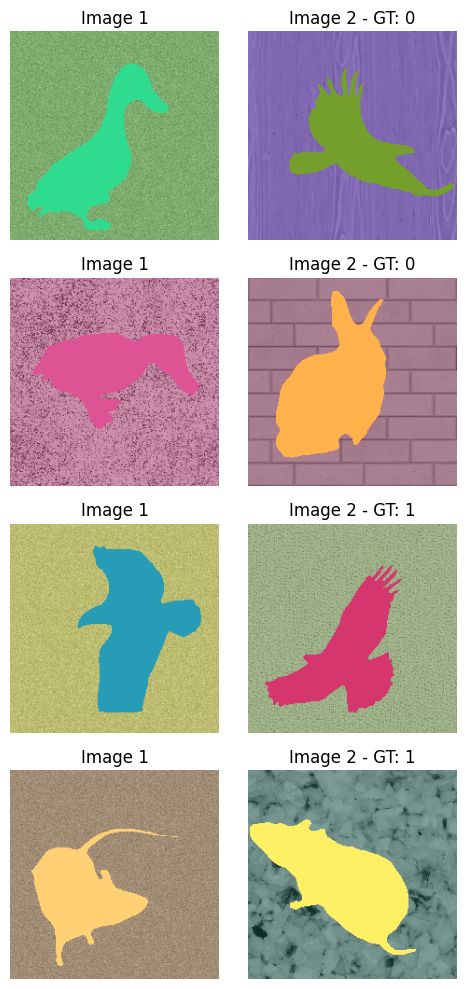

In [33]:
# Example usage to display 5 pairs of images
fig, axs = plt.subplots(4, 2, figsize=(5, 10))

for i in range(4):
    idx = np.random.randint(0, len(pretraining_dataset) - 1)
    img1, img2, gt = pretraining_dataset[idx]  # Get image pair and ground truth
    img1_pil = tensor_to_pil(img1)
    img2_pil = tensor_to_pil(img2)

    axs[i, 0].imshow(img1_pil)
    axs[i, 0].set_title('Image 1')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(img2_pil)
    axs[i, 1].set_title(f'Image 2 - GT: {gt}')
    axs[i, 1].axis('off')

plt.tight_layout()
#plt.savefig(dic + 'colortexurejitter6.pdf')
plt.show()

10) network

In [34]:
# experiment-dependent function to process an epoch of data
epoch_fun = osculari.paradigms.forced_choice.epoch_loop

In [35]:
dataset_loader = DataLoader(pretraining_dataset, 64)

In [36]:
lr = 0.01

In [37]:
#################################
# ResNet50: layer0, No pooling
#################################
#network
architecture = 'resnet50'        # network's architecture
weights = 'resnet50'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block0'                    # the readout layer
pooling = None                   # pooling
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture,
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling
}
resnet_model = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)

params_to_optimize = [{'params': [p for p in resnet_model.fc.parameters()]}]
optimiser = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)

# calling the generic train_linear_probe function
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    resnet_model, dataset_loader, epoch_fun, 'my_data/osculari_test/', device="cuda",
    epochs = 10,
    optimiser=optimiser
    )

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


[000] accuracy=0.508 loss=56540.292
[001] accuracy=0.497 loss=39431.495
[002] accuracy=0.496 loss=35715.081
[003] accuracy=0.494 loss=90386.286
[004] accuracy=0.497 loss=102690.718
[005] accuracy=0.497 loss=9535.109
[006] accuracy=0.492 loss=5598.536
[007] accuracy=0.487 loss=6103.444
[008] accuracy=0.491 loss=3822.449
[009] accuracy=0.503 loss=4065.013


In [38]:
# save model's weigths
PATH = dic + 'Tex_resnet_animal_layer0_NP.pt'
torch.save(resnet_model.state_dict(), PATH)

In [ ]:
#################################
# CLIP(ResNet50): layer0, No pooling
#################################
#network
architecture = 'clip_RN50'        # network's architecture
weights = 'clip_RN50'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block0'                    # the readout layer
pooling = None                   # pooling
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture,
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling
}
clip_model = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)

params_to_optimize = [{'params': [p for p in clip_model.fc.parameters()]}]
optimiser = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)

# calling the generic train_linear_probe function
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    clip_model, dataset_loader, epoch_fun, 'my_data/osculari_test/', device="cuda",
    epochs = 10,
    optimiser=optimiser
    )

100%|███████████████████████████████████████| 244M/244M [00:04<00:00, 53.2MiB/s]


[000] accuracy=0.519 loss=2024.518
[001] accuracy=0.497 loss=4604.616
[002] accuracy=0.490 loss=5826.848
[003] accuracy=0.504 loss=4748.045
[004] accuracy=0.490 loss=5064.734
[005] accuracy=0.516 loss=2454.501
[006] accuracy=0.500 loss=858.766
[007] accuracy=0.489 loss=452.384
[008] accuracy=0.504 loss=244.883
[009] accuracy=0.483 loss=256.093


In [ ]:
# save model's weigths
PATH = dic + 'Tex_clip_animal_layer0_NP.pt'
torch.save(clip_model.state_dict(), PATH)

In [ ]:
#################################
# CLIP(ViT): layer0, No pooling
#################################
#network
architecture = 'clip_ViT-B/32'        # network's architecture
weights = 'clip_ViT-B/32'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block0'                    # the readout layer
pooling = None                   # pooling
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture,
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling
}
clipViT_model = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)

params_to_optimize = [{'params': [p for p in clipViT_model.fc.parameters()]}]
optimiser = torch.optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=1e-4)

# calling the generic train_linear_probe function
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    clipViT_model, dataset_loader, epoch_fun, 'my_data/osculari_test/', device="cuda",
    epochs = 10,
    optimiser=optimiser
    )

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 86.5MiB/s]


[000] accuracy=0.482 loss=5.749
[001] accuracy=0.501 loss=6.516
[002] accuracy=0.499 loss=2.956
[003] accuracy=0.486 loss=3.163
[004] accuracy=0.493 loss=3.154
[005] accuracy=0.506 loss=3.533
[006] accuracy=0.498 loss=1.151
[007] accuracy=0.516 loss=1.054
[008] accuracy=0.495 loss=0.902
[009] accuracy=0.506 loss=0.886


In [ ]:
# save model's weigths
PATH = dic + 'Tex_clipViT_animal_layer0_NP.pt'
torch.save(clipViT_model.state_dict(), PATH)